# Notebook of Figure 3 of manuscript titled: _Variability of the kinetic energy in seasonally ice-covered oceans_.
by Josue Martinez-Moreno, Camille Lique, Claude Talandier, Quentin
Jamet, & Anne-Marie Treguier

This figure shows average properties of the idealized simulation including:
- Temperature,
- Salinity,
- Vertical Stratification,
- Horizonal buoyancy gradients,
- and kinetic energy.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
from dask.distributed import Client
import dask
import os

# os.environ["MALLOC_TRIM_THRESHOLD_"] = str(dask.config.get("distributed.nanny.environ.MALLOC_TRIM_THRESHOLD_"))
client =Client(n_workers=18, threads_per_worker=1, memory_limit="6 GiB",local_directory="/home1/scratch/jmartine/tmp")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 18
Total threads: 18,Total memory: 108.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59833,Workers: 18
Dashboard: http://127.0.0.1:8787/status,Total threads: 18
Started: Just now,Total memory: 108.00 GiB
Comm: tcp://127.0.0.1:57696,Total threads: 1
Dashboard: http://127.0.0.1:47297/status,Memory: 6.00 GiB
Nanny: tcp://127.0.0.1:36807,


In [3]:
import cmocean as cm

In [4]:
grid = xr.open_dataset('/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/GRID/domain_zgr_800x1200x50xr.nc')

In [6]:
# Define dimensions
Nx, Ny, Nz = 801, 1201, 32

X = np.ones((Ny,Nx,Nz)) * grid.x_coord.values[:,:,np.newaxis]
Y = np.ones((Ny,Nx,Nz)) * grid.y_coord.values[:,:,np.newaxis]
Z = -np.ones((Ny,Nx,Nz)) * grid.gdept_1d.sel(nav_lev=slice(0,200)).values[:]

## LOAD DATA

In [7]:
from utils import Import_Expt_Front, date_fmt

In [8]:
folder = '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/'
EXF = Import_Expt_Front(folder)

In [9]:
exp_filter = ['expt_001','expt_002','expt_003','expt_004','expt_005','expt_007','expt_008','expt_009','expt_010','expt_250m_test']


In [10]:
dataset_gridT_1d = EXF.import_multipe_expt('grid_T',expt_filter=exp_filter,freq='1d',chunks={'time_counter':1,'deptht':5,'x':551,'y':551})


In [11]:
dataset_gridW_1d = EXF.import_multipe_expt('grid_W',expt_filter=exp_filter,freq='1d',chunks={'time_counter':1,'depthw':5,'x':551,'y':551})


In [12]:
dataset_ice_1d = EXF.import_multipe_expt('icemod',vars_of_interest=['iceconc','icevolu'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':5,'x':251,'y':251})


Compute mean temperature and salinity

In [17]:
TEMP = dataset_gridT_1d.toce_006.sel(time_counter="0002").mean(("x","y")).compute()
SALT = dataset_gridT_1d.soce_006.sel(time_counter="0002").mean(("x","y")).compute()

Compute the mean mixed layer depth

In [58]:
mean_MLD = dataset_gridT_1d.mldr10_1_006.sel(time_counter="0002").mean(("x","y")).compute()
std_MLD = dataset_gridT_1d.mldr10_1_006.sel(time_counter="0002").std(("x","y")).compute()


Compute the mean and standard deviation of the ice volume

In [14]:
mean_ivol = dataset_ice_1d.icevolu_006.sel(time_counter="0002").mean(("x","y")).compute()
std_ivol = dataset_ice_1d.icevolu_006.sel(time_counter="0002").std(("x","y")).compute()

Compute and store mean kinetic energy

In [15]:
# Compute and store data (Easier for post-processing)
# mean_KE = dataset_gridT_1d.ke_006.sel(time_counter="0002").mean(("x","y")).compute()
# mean_KE.to_netcdf("storage/mean_KE_time_series.nc")

In [16]:
# Load stored data
mean_KE = xr.open_dataset("./storage/mean_KE_time_series.nc")

In [18]:
W = dataset_gridW_1d.woce_006.sel(time_counter="0002").mean(("x","y")).compute()

Compute vertical stratification (vertical buoyancy gradients)

In [19]:
N2 = dataset_gridW_1d.bn2_006

In [20]:
# Compute and store data (Easier for post-processing)
# mean_N2 = N2.sel(time_counter="0002").mean(("x","y")).compute()
# mean_N2.to_netcdf("storage/mean_N2_time_series.nc")

In [21]:
# Load stored data
mean_N2 = xr.open_dataset("storage/mean_N2_time_series.nc")

Compute horizontal buoyancy gradients

In [22]:
rho_0 = 1026
g = 9.81
b = -g *( dataset_gridT_1d.rhop_006 - rho_0 )/ rho_0

In [29]:
db_dx = b.diff("x")/grid.e1t.isel(x=slice(0,-1)).squeeze()

In [30]:
db_dy = b.isel(y=slice(1,-1)).diff("y")/grid.e2t.isel(y=slice(1,-2)).squeeze()

In [31]:
M4 =  ((db_dx.isel(y=slice(1,-2))**2 + db_dy.isel(x=slice(0,-1))**2)).rename("M4")

M2 =  np.sqrt(db_dx.isel(y=slice(1,-2))**2 + db_dy.isel(x=slice(0,-1))**2).rename("M2")

In [32]:
# Compute and store data (Easier for post-processing)
mean_M2 = M2.sel(time_counter="0002").mean(("x","y")).compute()
mean_M2.to_netcdf("storage/mean_M2_time_series_corrected.nc")

In [36]:
# Compute and store data (Easier for post-processing)
mean_M4 = M4.sel(time_counter="0002").mean(("x","y")).compute()
mean_M4.to_netcdf("storage/mean_M4_time_series_corrected.nc")

In [38]:
mean_M4 = xr.open_dataset("storage/mean_M4_time_series_corrected.nc")

In [39]:
from matplotlib import colors
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import datetime

In [41]:
def axis_to_fig(axis):
    fig = axis.figure
    def transform(coord):
        return fig.transFigure.inverted().transform(
            axis.transAxes.transform(coord))
    return transform

def add_sub_axes(axis, rect,**kwargs):
    fig = axis.figure
    left, bottom, width, height = rect
    trans = axis_to_fig(axis)
    figleft, figbottom = trans((left, bottom))
    figwidth, figheight = trans([width,height]) - trans([0,0])
    return fig.add_axes([figleft, figbottom, figwidth, figheight],**kwargs)

def myfmt(x, pos):
    return '{0:.2f}'.format(x)


def date_fmt(date):
    if len(date)>2:
        format = '%m-%d'
        outformat = '%d - %B'
    else:
        format = '%m'
        outformat = '%B'
    return datetime.datetime.strptime(str(date), format).strftime(outformat)

/dev/shm/pbs.3117406.datarmor0/ipykernel_26290/2446848134.py:139: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax5.set_xticklabels(updated_labels,fontsize=12)


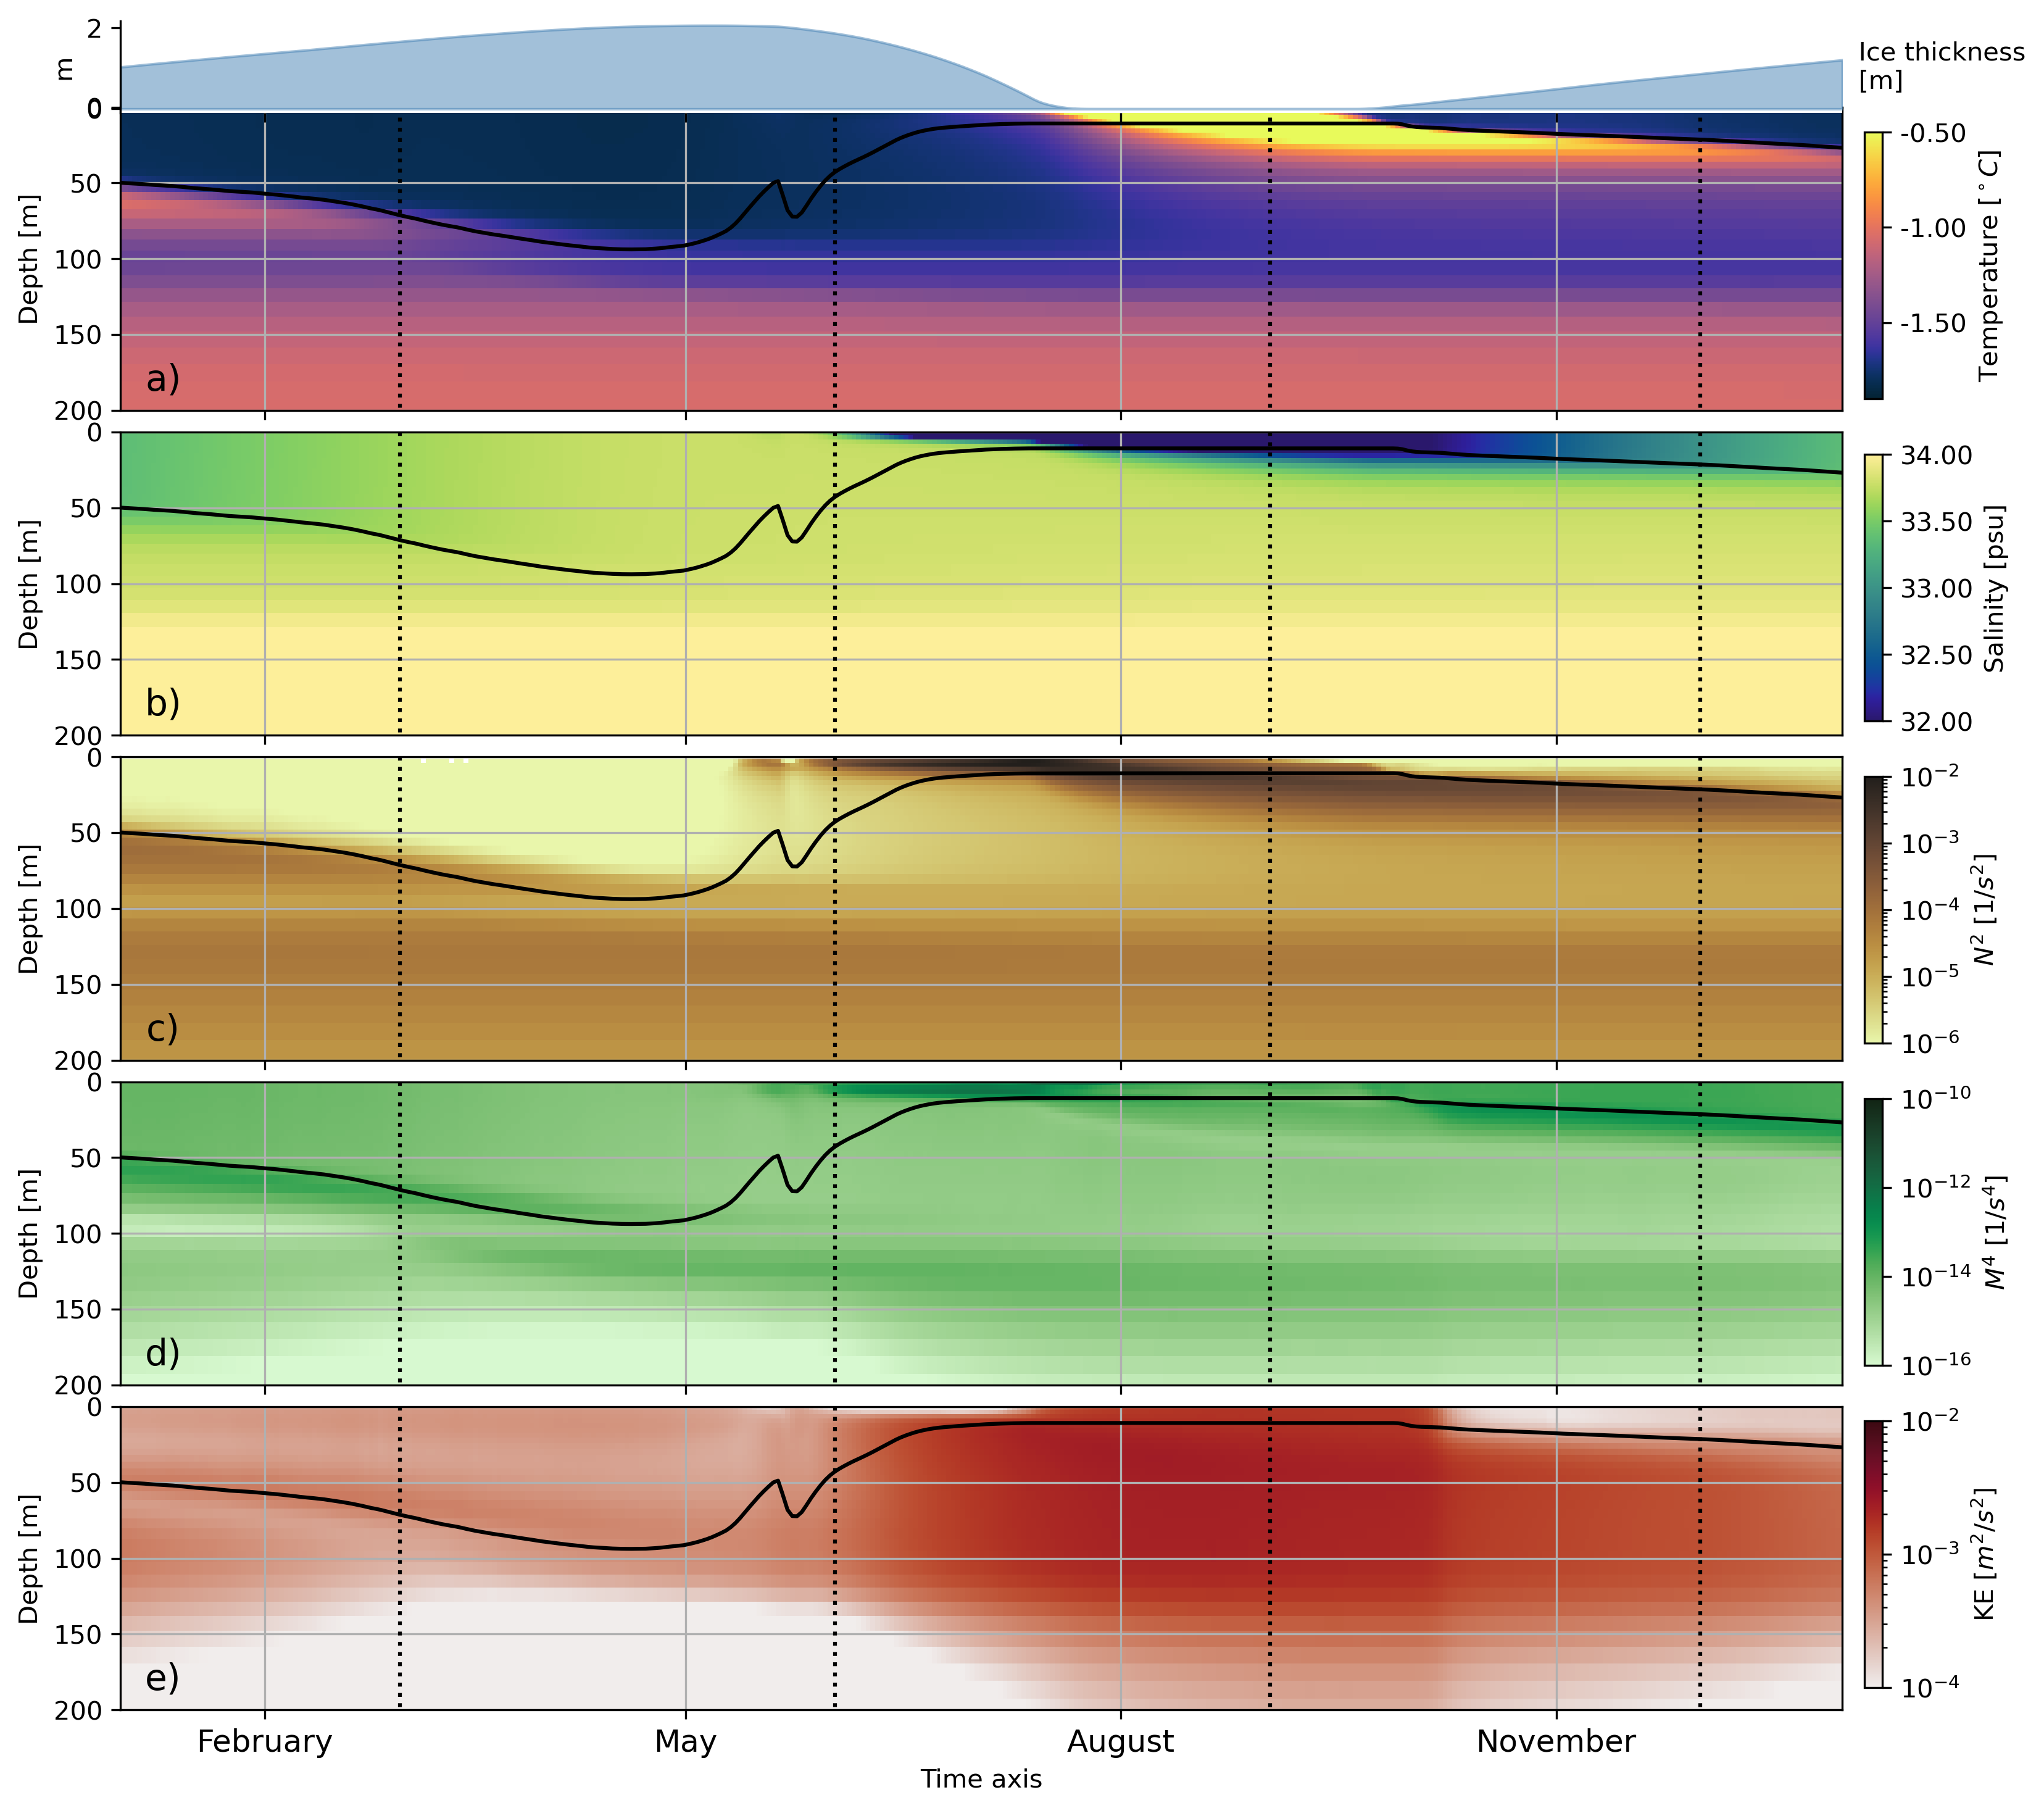

In [62]:
# Create a figure with 3D ax
fig = plt.figure(figsize=(12, 12),dpi=300)


gs = GridSpec(16, 4, figure=fig)

########################################################################
ax1 = fig.add_subplot(gs[1:4, :])

C1 = TEMP.plot(x='time_counter',ax=ax1,cmap=cm.cm.thermal, vmin= -1.9, vmax=-0.5,add_colorbar=False,rasterized=True)
mean_MLD.plot(ax=ax1, x='time_counter', color='k')

ax2 = fig.add_subplot(gs[4:7, :],sharey=ax1)

C2 = SALT.plot(x='time_counter',ax=ax2,cmap=cm.cm.haline, vmin=32, vmax=34,add_colorbar=False,rasterized=True)
mean_MLD.plot(ax=ax2, x='time_counter', color='k')

ax3 = fig.add_subplot(gs[7:10, :],sharey=ax1)

C3 = mean_N2.bn2_006.plot(x='time_counter',ax=ax3,cmap=cm.cm.turbid, vmin= 1e-6, vmax=1e-2, norm= colors.LogNorm(),add_colorbar=False,rasterized=True)
mean_MLD.plot(ax=ax3, x='time_counter', color='k')

ax4 = fig.add_subplot(gs[10:13, :],sharey=ax1)

C4 = (mean_M4.M4).plot(x='time_counter',ax=ax4,cmap=cm.cm.algae, vmin= 1e-16, vmax=1e-10, norm= colors.LogNorm(),add_colorbar=False,rasterized=True)
mean_MLD.plot(ax=ax4, x='time_counter', color='k')

ax5 = fig.add_subplot(gs[13:, :],sharey=ax1)

C5 = mean_KE.ke_006.plot(x='time_counter',ax=ax5,cmap=cm.cm.amp, vmin= 1e-4, vmax=1e-2, norm= colors.LogNorm(),add_colorbar=False,rasterized=True)
mean_MLD.plot(ax=ax5, x='time_counter', color='k')

# ax5.plot([mean_KE.time_counter.values[85],mean_KE.time_counter.values[85]],[0,200],color='w',linestyle="--",linewidth=0.7)
# ax5.plot([mean_KE.time_counter.values[230],mean_KE.time_counter.values[230]],[0,200],color='w',linestyle="--",linewidth=0.7)

[ ax.set_ylim(0,200) for ax in [ax1,ax2, ax3,ax4,ax5]]
[ ax.set_xlim((mean_MLD.time_counter.values[0],mean_MLD.time_counter.values[-1]))  for ax in [ax1,ax2,ax3,ax4,ax5]]
[ ax.set_ylabel("Depth [m]") for ax in [ax1,ax2,ax3,ax4,ax5]]
[ ax.grid() for ax in [ax1,ax2,ax3,ax4,ax5]]


########################################################################
time = mean_N2.time_counter

snapshot1 = time.sel(time_counter='0002-03-01').values
ttime = np.array([snapshot1.flatten()[0],snapshot1.flatten()[0]])

ax1.plot(ttime,[0,200],linestyle=':',color='k')
ax2.plot(ttime,[0,200],linestyle=':',color='k')
ax3.plot(ttime,[0,200],linestyle=':',color='k')
ax4.plot(ttime,[0,200],linestyle=':',color='k') 
ax5.plot(ttime,[0,200],linestyle=':',color='k') 

# ax5.text(ttime[0],210,"0002-03-10")

snapshot2 = time.sel(time_counter='0002-06-01').values
ttime = np.array([snapshot2.flatten()[0],snapshot2.flatten()[0]])

ax1.plot(ttime,[0,200],linestyle=':',color='k')
ax2.plot(ttime,[0,200],linestyle=':',color='k')
ax3.plot(ttime,[0,200],linestyle=':',color='k')
ax4.plot(ttime,[0,200],linestyle=':',color='k') 
ax5.plot(ttime,[0,200],linestyle=':',color='k') 


snapshot2 = time.sel(time_counter='0002-09-01').values
ttime = np.array([snapshot2.flatten()[0],snapshot2.flatten()[0]])

ax1.plot(ttime,[0,200],linestyle=':',color='k')
ax2.plot(ttime,[0,200],linestyle=':',color='k')
ax3.plot(ttime,[0,200],linestyle=':',color='k')
ax4.plot(ttime,[0,200],linestyle=':',color='k') 
ax5.plot(ttime,[0,200],linestyle=':',color='k') 

snapshot2 = time.sel(time_counter='0002-12-01').values
ttime = np.array([snapshot2.flatten()[0],snapshot2.flatten()[0]])

ax1.plot(ttime,[0,200],linestyle=':',color='k')
ax2.plot(ttime,[0,200],linestyle=':',color='k')
ax3.plot(ttime,[0,200],linestyle=':',color='k')
ax4.plot(ttime,[0,200],linestyle=':',color='k') 
ax5.plot(ttime,[0,200],linestyle=':',color='k') 

# ax5.text(ttime[0],210,"0002-08-02")
########################################################################

ax3.invert_yaxis()

[ ax.set_xticklabels([])  for ax in [ax1,ax2,ax3,ax4] ] 
[ ax.set_xlabel('')  for ax in [ax1,ax2,ax3,ax4] ] 



iceax = add_sub_axes(ax1,[0., 0.98, 1, 0.3])#,sharex=ax3)
iceax.fill_between(mean_ivol.time_counter.values, mean_ivol*0,mean_ivol,alpha=0.5,color='steelblue')
iceax.spines[['right', 'top', 'bottom']].set_visible(False)
iceax.set_xticklabels([])
iceax.set_xlim((mean_ivol.time_counter.values[0],mean_ivol.time_counter.values[-1]))
iceax.set_ylabel("m")

iceax.text(time.sel(time_counter='0002-12-31').values, 0.5, "  Ice thickness\n  [m]", fontsize=10)

########################################################################


# Colorbar
cax = fig.add_axes([0.91, 0.70, 0.008, 0.12])
fig.colorbar(C1, cax=cax, format=ticker.FuncFormatter(myfmt))
cax.set_ylabel('Temperature [$^\circ C$]')


cax = fig.add_axes([0.91, 0.555, 0.008, 0.12])
fig.colorbar(C2, cax=cax, format=ticker.FuncFormatter(myfmt))
cax.set_ylabel('Salinity [psu]')

cax = fig.add_axes([0.91, 0.41, 0.008, 0.12])
fig.colorbar(C3, cax=cax, orientation='vertical')
cax.set_ylabel('$N^2$ [$1/s^2$]')

cax = fig.add_axes([0.91, 0.265, 0.008, 0.12])
fig.colorbar(C4, cax=cax, orientation='vertical')
cax.set_ylabel(r'$M^4$ [$1/s^4$]')

cax = fig.add_axes([0.91, 0.12, 0.008, 0.12])
fig.colorbar(C5, cax=cax, orientation='vertical')
cax.set_ylabel('KE [$m^2/s^2$]')


ax1.text(time.sel(time_counter='0002-01-10').values, 180, 'a)', horizontalalignment='center', verticalalignment='center', fontsize=14)
ax2.text(time.sel(time_counter='0002-01-10').values, 180, 'b)', horizontalalignment='center', verticalalignment='center', fontsize=14)
ax3.text(time.sel(time_counter='0002-01-10').values, 180, 'c)', horizontalalignment='center', verticalalignment='center', fontsize=14)
ax4.text(time.sel(time_counter='0002-01-10').values, 180, 'd)', horizontalalignment='center', verticalalignment='center', fontsize=14)
ax5.text(time.sel(time_counter='0002-01-10').values, 180, 'e)', horizontalalignment='center', verticalalignment='center', fontsize=14)

plt.draw()

labels = [item.get_text() for item in ax5.get_xticklabels()]
updated_labels = [ date_fmt(label[5:10]) for label in labels]
ax5.set_xticklabels(updated_labels,fontsize=12)


plt.subplots_adjust(hspace=0.25, wspace=-0.3)

# Save Figure
plt.savefig('./figures/Fig_2_hovemoller.pdf', dpi=300, bbox_inches='tight')

**Figure 3.** Hovm\"oller diagrams during the second year of the simulation show the domain
averaged (a) temperature, (b) salinity, (c) vertical stratification ($N^2$), (d) squared horizontal
buoyancy gradients ($M^4$), and e) kinetic energy. Additionally, the mixed layer depth is shown
with the black solid line in all panels. The ice thickness is shown above panel a). Vertical dotted
lines correspond to the first day of the different seasons.

### Print some extra diagnostics

In [59]:
print("Min ice thickness")
print(mean_ivol.min().compute())

print("Max ice thickness")
print(mean_ivol.max().compute())

Min ice thickness
<xarray.DataArray 'icevolu_006' ()>
array(0., dtype=float32)
Max ice thickness
<xarray.DataArray 'icevolu_006' ()>
array(2.0616155, dtype=float32)


In [60]:
print("Min MLD")
print(mean_MLD.min().compute())

print("Max MLD")
print(mean_MLD.max().compute())

Min MLD
<xarray.DataArray 'mldr10_1_006' ()>
array(10.765156, dtype=float32)
Max MLD
<xarray.DataArray 'mldr10_1_006' ()>
array(93.807014, dtype=float32)
